In [31]:
import numpy as np
import mdtraj as md 
import deeptime
from deeptime.decomposition import TICA
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
from itertools import combinations
import matplotlib.pyplot as plt

from glob import glob

In [32]:
Temperatures = [280,283,286,289,292,295,298,301,304,307,310,313,316,320,323,326,330,333,336,340,343,347,350,354,358,361,365,369,372,376,380,384,388,392,396,400]

T = Temperatures[7]

#pos_path = '/local_scratch2/jacopo/trans_temp/all_atom_replica_results_chignolin/exchange_neighbors/coords_nowater'
pos_path = '/local_scratch2/jacopo/trans_temp/all_atom_replica_results_chignolin/exchange_all/coords_nowater'

pos_path2 = '/local_scratch2/jacopo/trans_temp/all_atom_replica_results_chignolin/exchange_all/not_shure/coords_nowater'

In [33]:
dihedral_atoms = [(i, i+1, i+2, i+3) for i in range(7)]
angle_atoms = [(i, i+1, i+2) for i in range(8)]
print(f'Dihedral atoms: {dihedral_atoms}')

distances = []
dihedrals = []
angles = []
coords = []
rmsds = []




coord_fns = sorted(glob(f'{pos_path}/temperature_{T}/coor*'))
coord_fns2 = sorted(glob(f'{pos_path2}/temperature_{T}/coor*'))
#assert len(coord_fns) == 3744

# load topology and consider CA resolution
chig_pdb = md.load("./chi_sys.pdb").remove_solvent()

ca_idx = chig_pdb.topology.select("name CA")
print(f'CA indeces: {ca_idx}')

assert len(ca_idx) == 10

for fn in coord_fns:
    coords = np.load(fn) / 10.0
    aa_pdb = md.Trajectory(xyz=coords, topology=chig_pdb.topology, time=np.arange(len(coords)))
    cg_pdb = aa_pdb.atom_slice(ca_idx)
    ca_atoms = cg_pdb.topology.select("name CA")
    ca_atom_pairs = list(combinations(ca_atoms, 2))

    distances_fn = md.compute_distances(cg_pdb, ca_atom_pairs)
    dihedrals_fn = md.compute_dihedrals(cg_pdb, dihedral_atoms)
    angles_fn = md.compute_angles(cg_pdb, angle_atoms)
    rmsd_fn = md.rmsd(aa_pdb, chig_pdb, frame=-1)
    distances.append(distances_fn)
    dihedrals.append(dihedrals_fn)
    angles.append(angles_fn)
    rmsds.append(rmsd_fn)


for fn in coord_fns2:
    coords = np.load(fn) / 10.0
    aa_pdb = md.Trajectory(xyz=coords, topology=chig_pdb.topology, time=np.arange(len(coords)))
    cg_pdb = aa_pdb.atom_slice(ca_idx)
    ca_atoms = cg_pdb.topology.select("name CA")
    ca_atom_pairs = list(combinations(ca_atoms, 2))

    distances_fn = md.compute_distances(cg_pdb, ca_atom_pairs)
    dihedrals_fn = md.compute_dihedrals(cg_pdb, dihedral_atoms)
    angles_fn = md.compute_angles(cg_pdb, angle_atoms)
    rmsd_fn = md.rmsd(aa_pdb, chig_pdb, frame=-1)
    distances.append(distances_fn)
    dihedrals.append(dihedrals_fn)
    angles.append(angles_fn)
    rmsds.append(rmsd_fn)

all_distances = np.concatenate(distances)
all_dihedrals = np.concatenate(dihedrals)
all_angles = np.concatenate(angles)
all_rmsds = np.concatenate(rmsds)
print(f'Shape of all distances: {all_distances.shape}')

Dihedral atoms: [(0, 1, 2, 3), (1, 2, 3, 4), (2, 3, 4, 5), (3, 4, 5, 6), (4, 5, 6, 7), (5, 6, 7, 8), (6, 7, 8, 9)]
CA indeces: [  8  29  50  70  76  91 105 112 126 150]
Shape of all distances: (69630, 45)


Text(0, 0.5, 'timescale (steps)')

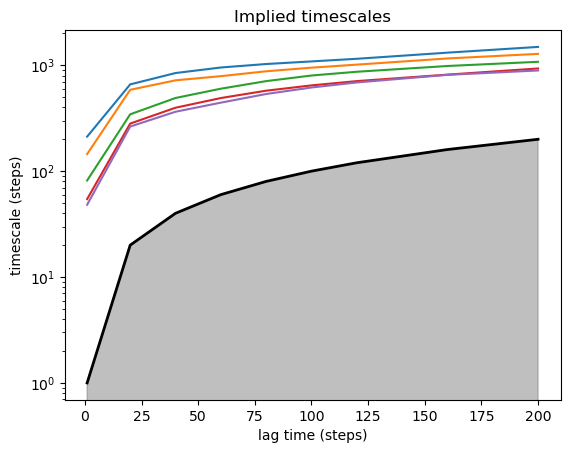

In [34]:
lags =[1,20,40,60,80,100,120,160,200]
models = []
for lag in lags:
    tica = TICA(lagtime=lag, dim=2, scaling='kinetic_map')
    models.append(tica.fit_fetch(distances))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=5, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

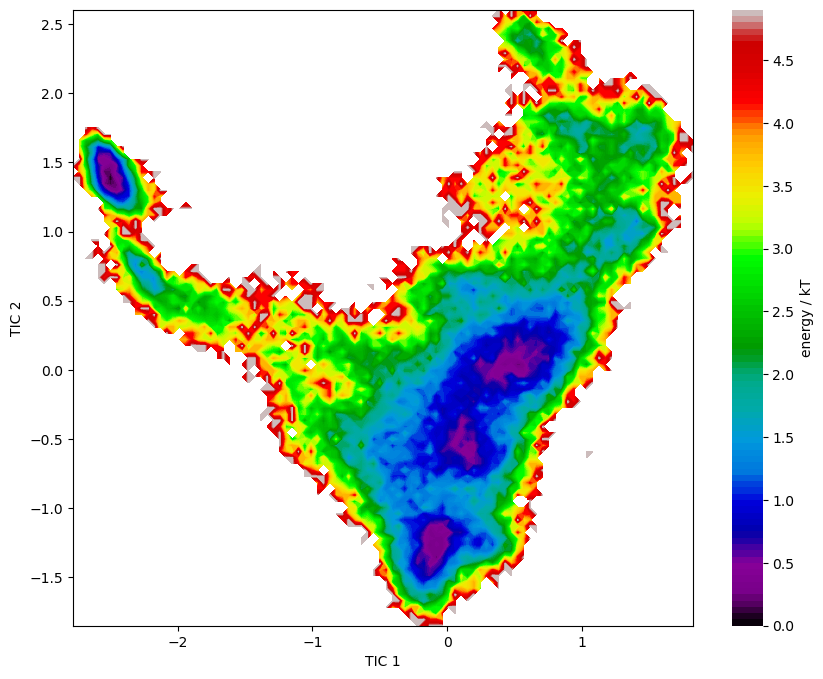

In [35]:
# Plot ref TICA
chosen_tica = TICA(lagtime=100, dim=2, scaling='kinetic_map')

tica_projection = chosen_tica.fit_transform(all_distances)

fig, ax = plt.subplots(figsize=(10, 8))
energy_landscape = deeptime.util.energy2d(*tica_projection.T, kbt=1.0, shift_energy=True)
ax, contour, cbar = energy_landscape.plot(contourf_kws=dict(cmap='nipy_spectral'))
cbar.set_label('energy / kT')


ax.set_ylabel('TIC 2')
ax.set_xlabel('TIC 1')

plt.show()


## Single trajectory analisis

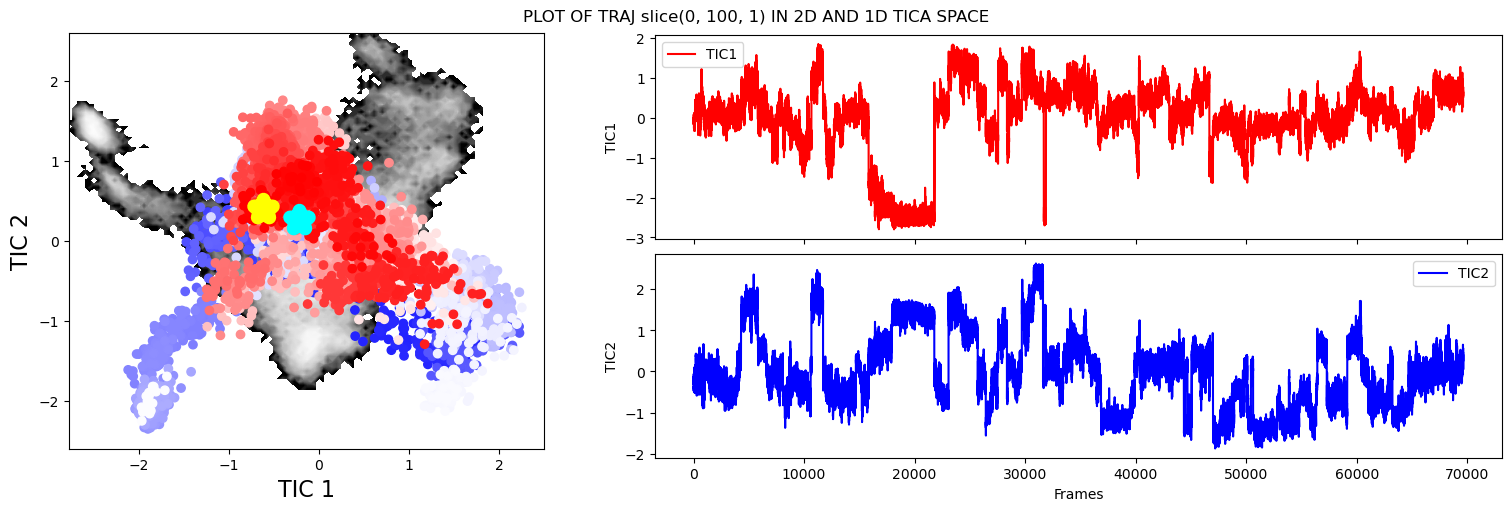

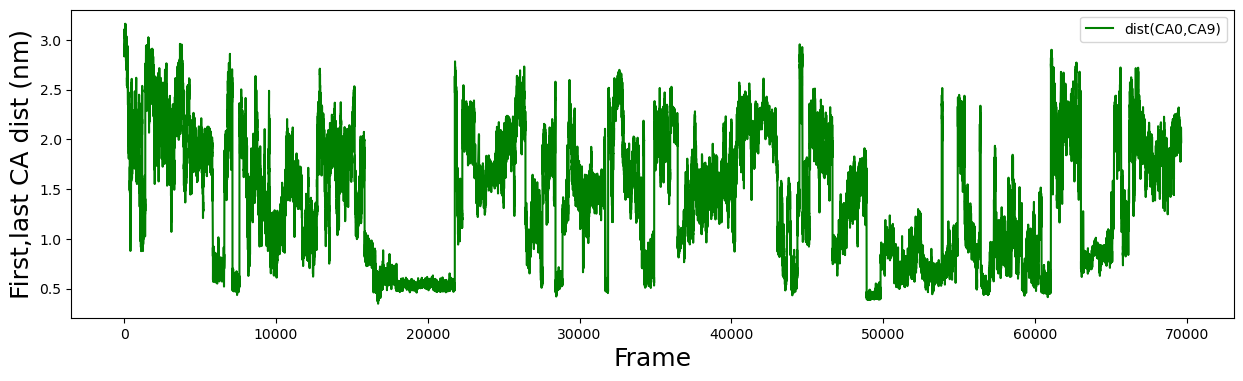

In [36]:
# Select a trajectory or a trajectories interval 
traj_number = slice(0,100,1)
# Select lagtime 
lagtime =80 


selected_distances = np.concatenate(distances[traj_number])

tica = TICA(lagtime=lagtime, dim=2, scaling='kinetic_map')
sub_projected_tics = tica.fit_transform(selected_distances)

fig = plt.figure(layout="constrained", figsize=(15,5))
fig.suptitle('PLOT OF TRAJ {} IN 2D AND 1D TICA SPACE'.format(traj_number))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.2, 2.])

# 2D plot
axs0 = subfigs[0].subplots(1, 1)

energy_landscape = deeptime.util.energy2d(*tica_projection.T, kbt=1.0, shift_energy=True)
ax, contour, cbar = energy_landscape.plot(contourf_kws=dict(cmap='Greys'), cbar=False, ax = axs0)
ax.scatter(sub_projected_tics[::10,0], sub_projected_tics[::10,1],
                c=np.arange(len(sub_projected_tics[::10])), cmap='bwr')
ax.scatter(sub_projected_tics[0,0],sub_projected_tics[0,1], c="cyan", marker='*', linewidth=10, s=200)
ax.scatter(sub_projected_tics[-1,0],sub_projected_tics[-1,1], c="yellow", marker='*',linewidth=10, s=200)
ax.set_xlabel("TIC 1", fontsize=16)
ax.set_ylabel("TIC 2", fontsize=16)

# 2 1D plot of reaction coordinates
axs1 = subfigs[1].subplots(2, 1, sharex=True)

axs1[0].plot(tica_projection[:, 0], color='red', label='TIC1')
axs1[0].set_ylabel('TIC1')
axs1[0].legend(loc='best')

axs1[1].plot(tica_projection[:, 1], color='blue', label='TIC2')
axs1[1].set_ylabel('TIC2')
axs1[1].set_xlabel('Frames')
axs1[1].legend(loc='best')
plt.show()

# Distance between first and last CA plot
first_last_distance = all_distances[:,8]

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(first_last_distance, color='green', label='dist(CA0,CA9)')
ax.set_xlabel("Frame", fontsize=18)
ax.set_ylabel("First,last CA dist (nm)", fontsize=18)
ax.legend(loc='best')
plt.show()

# RMSD plot 
#selected_rmsd = np.concatenate(rmsds[traj_number])
#fig, ax = plt.subplots(figsize=(15,2))
#ax.set_ylim(0,1.5)
#ax.set_xlabel("Frame", fontsize=18)
#ax.set_ylabel("RMSD (nm)", fontsize=18)
#ax.plot(selected_rmsd, color='green',alpha=0.4,label="RMSD to Native State")
#
#plt.show()


(0, 1)


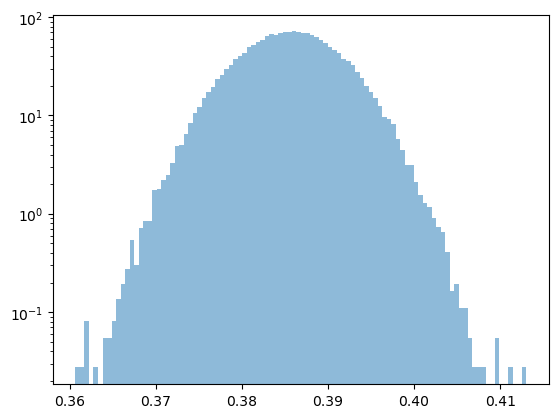

(0, 2)


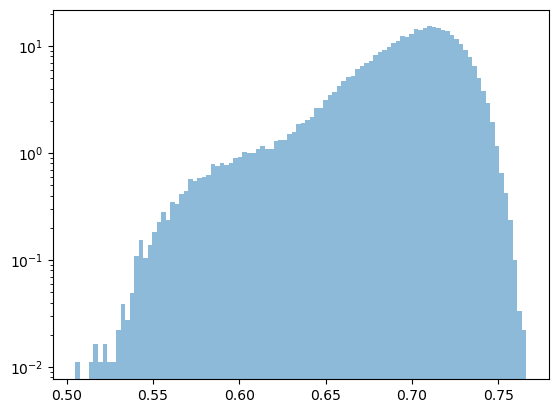

(0, 3)


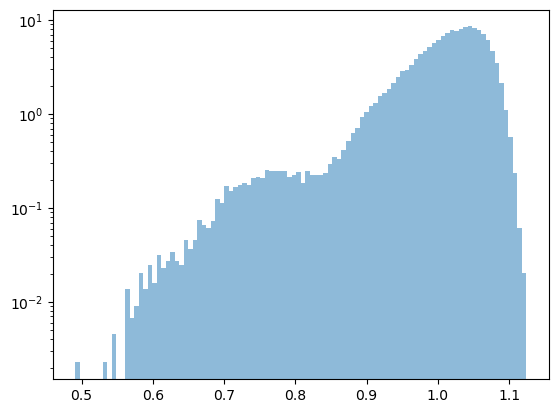

(0, 4)


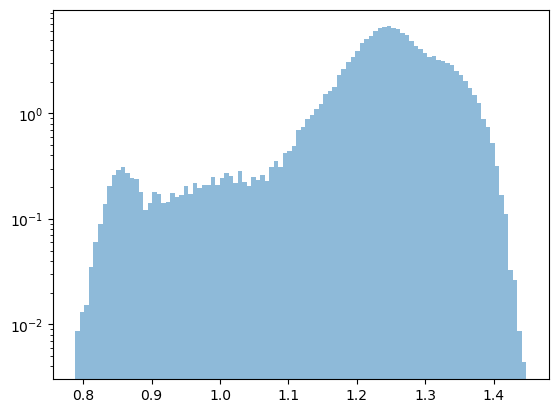

(0, 5)


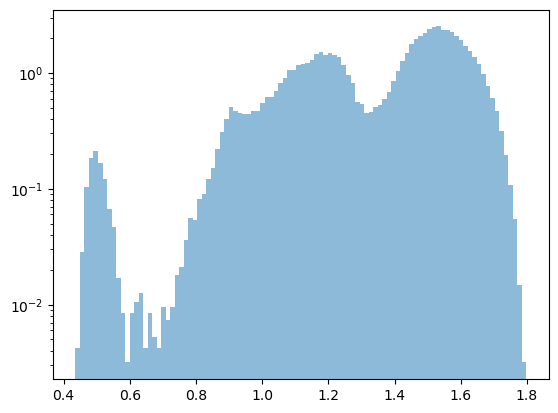

(0, 6)


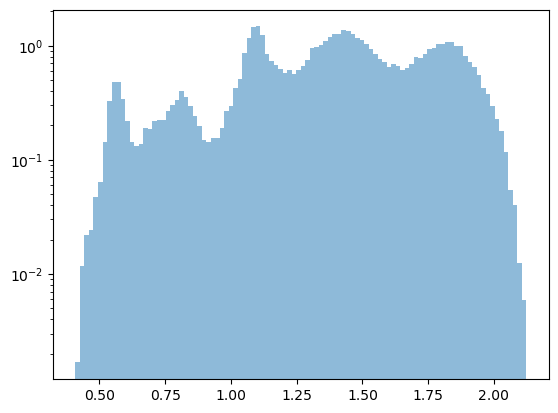

(0, 7)


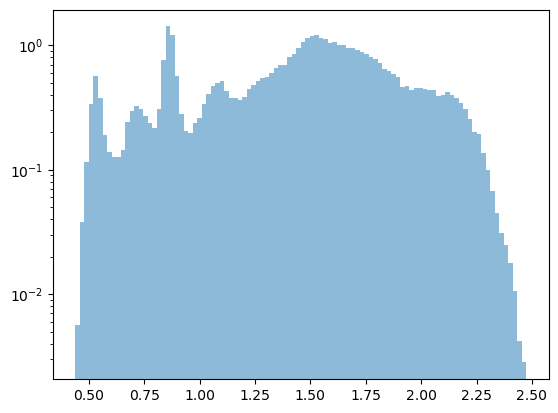

(0, 8)


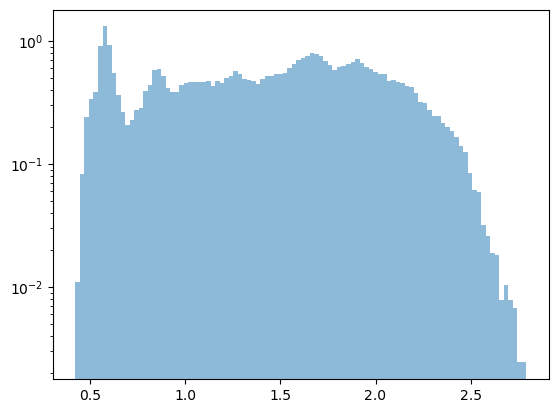

(0, 9)


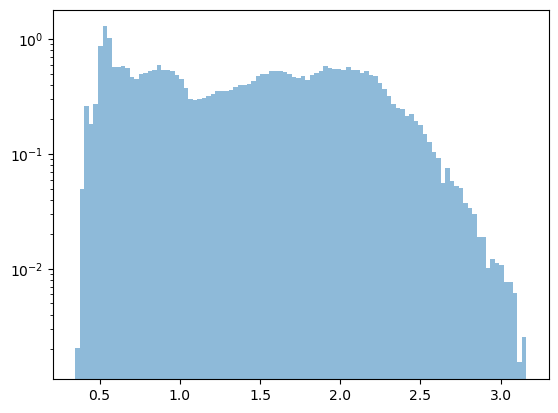

(1, 2)


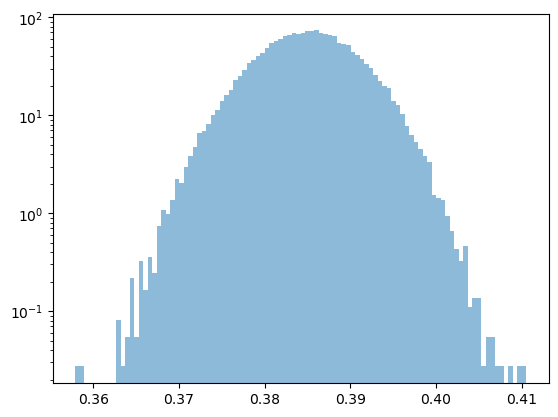

(1, 3)


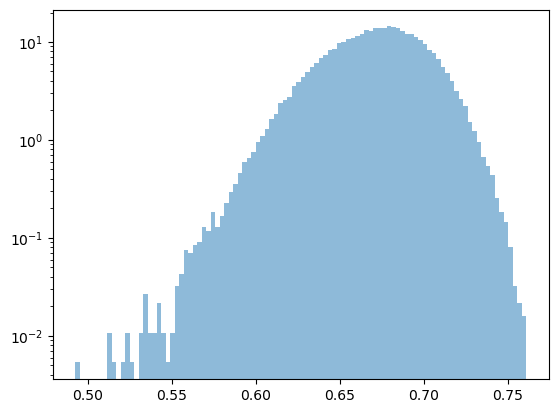

(1, 4)


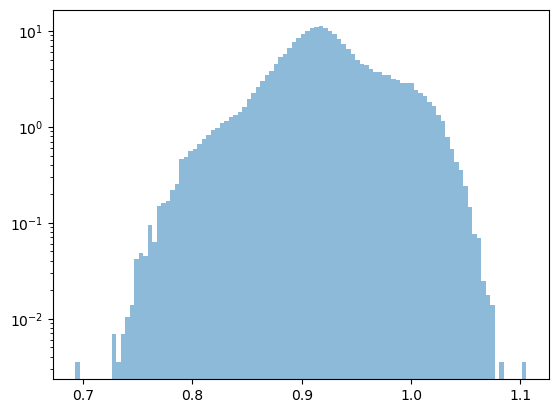

(1, 5)


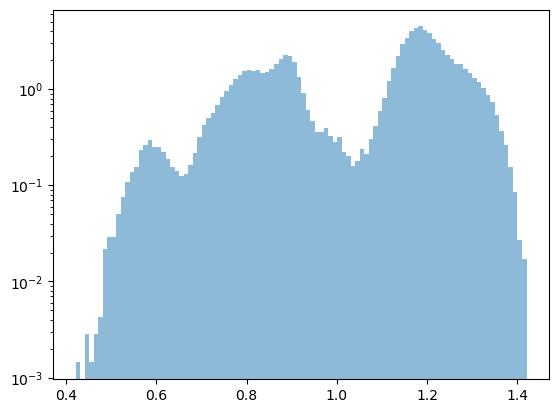

(1, 6)


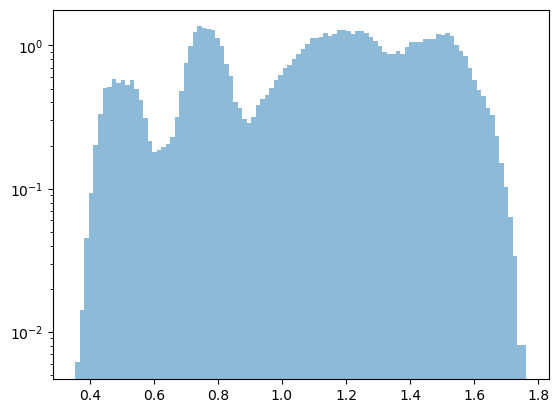

(1, 7)


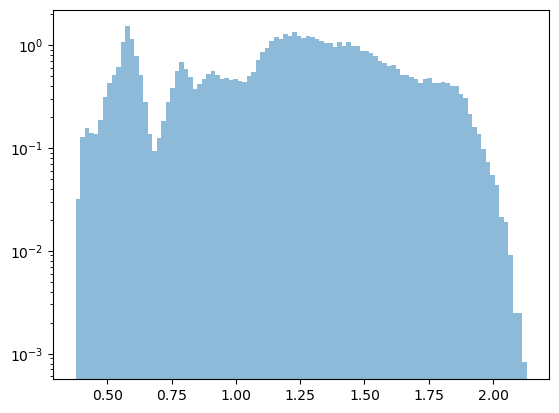

(1, 8)


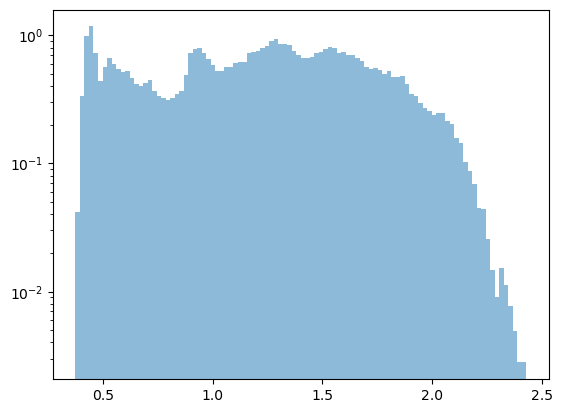

(1, 9)


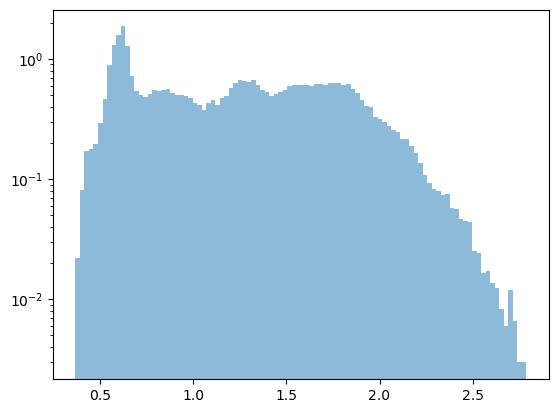

(2, 3)


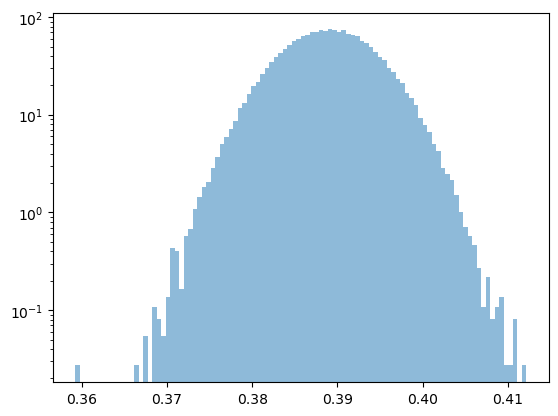

(2, 4)


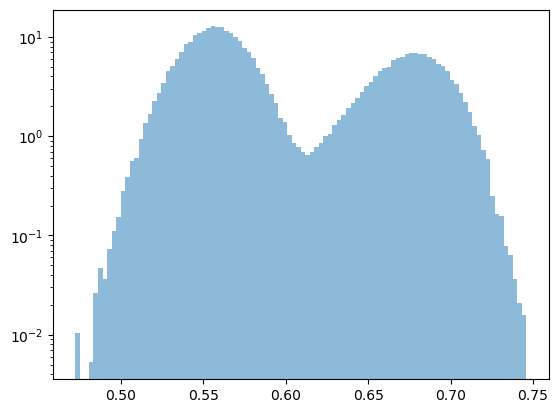

(2, 5)


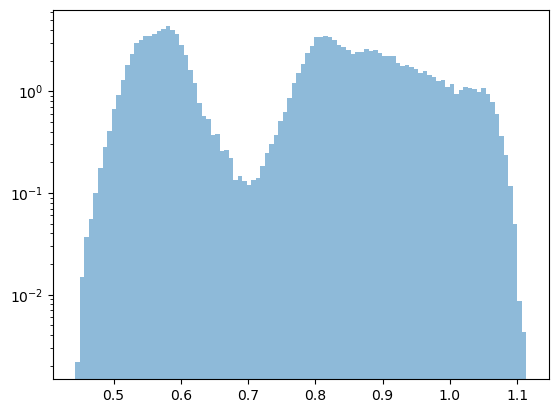

(2, 6)


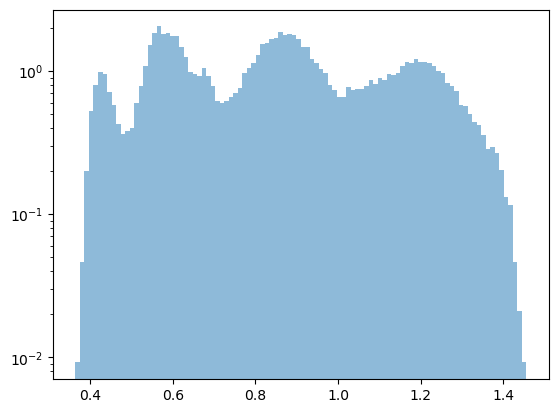

(2, 7)


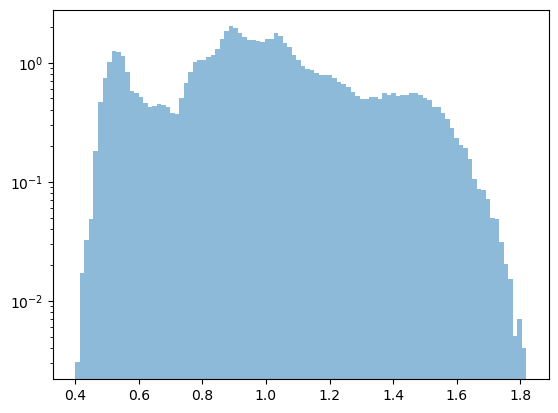

(2, 8)


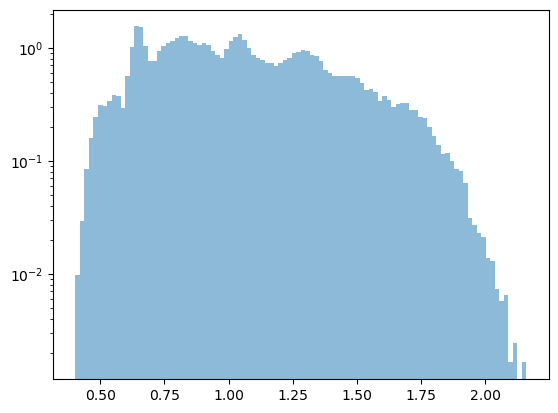

(2, 9)


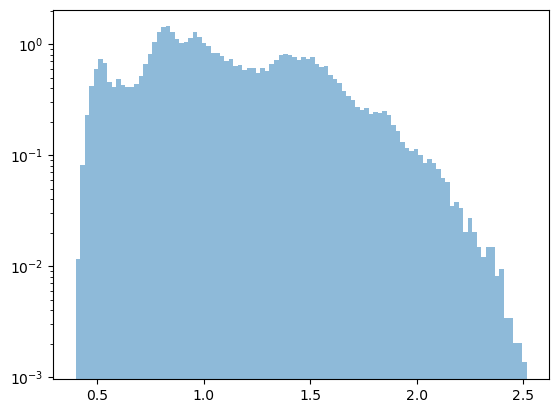

(3, 4)


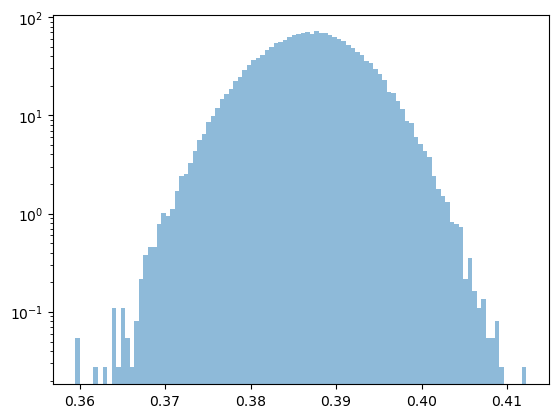

(3, 5)


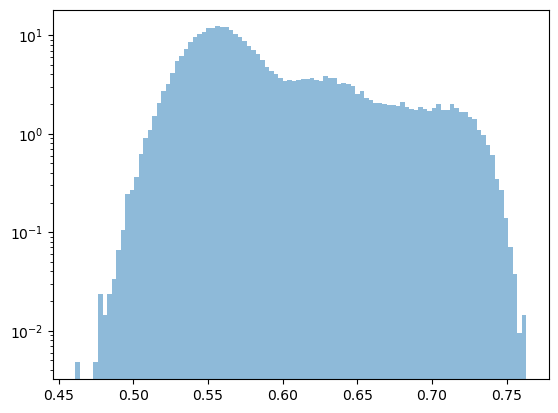

(3, 6)


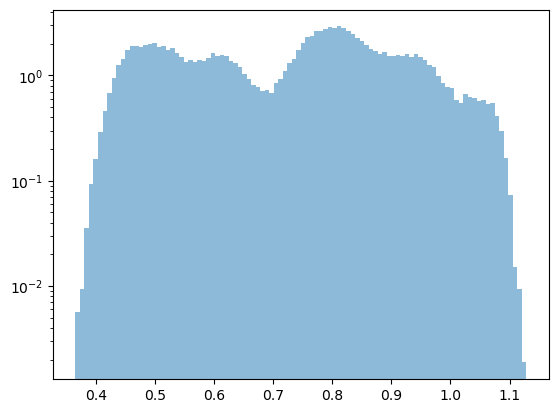

(3, 7)


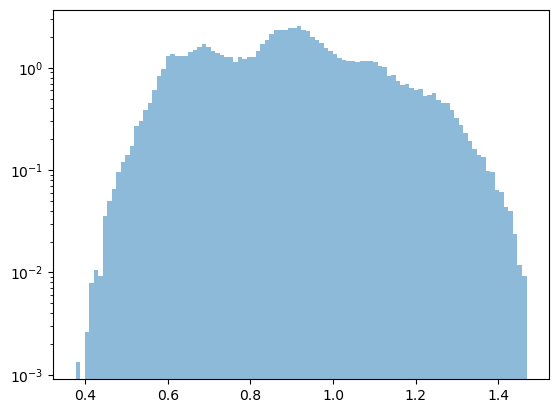

(3, 8)


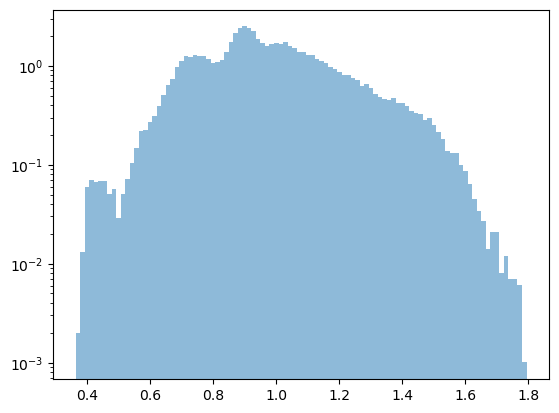

(3, 9)


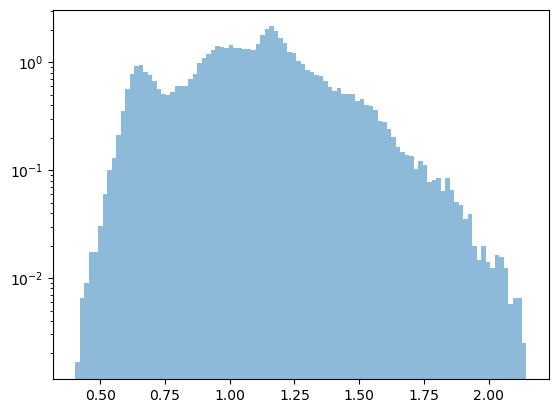

(4, 5)


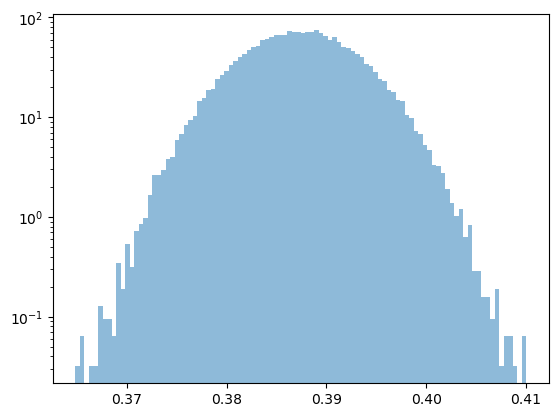

(4, 6)


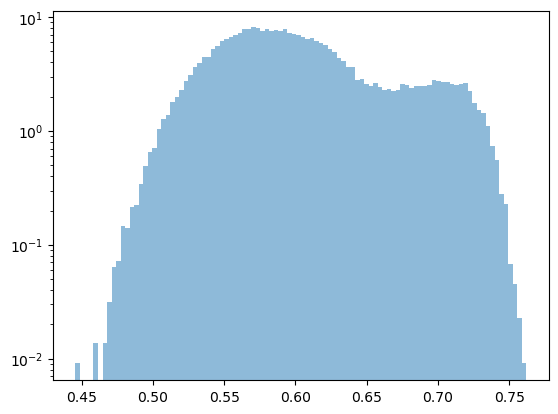

(4, 7)


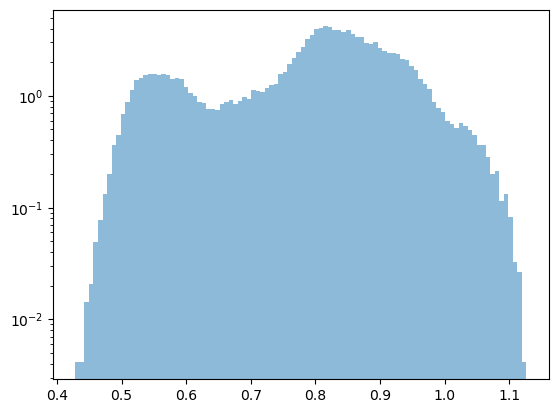

(4, 8)


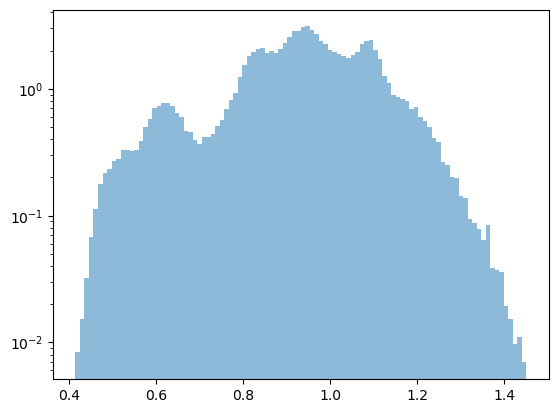

(4, 9)


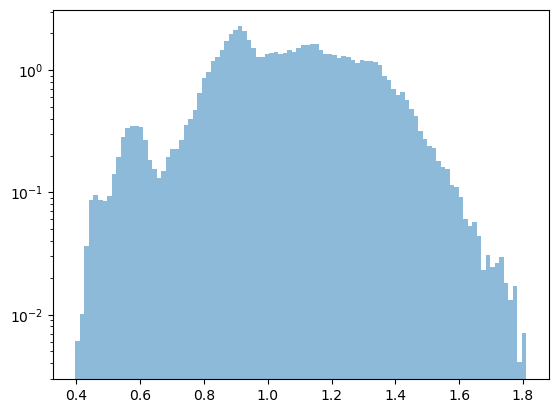

(5, 6)


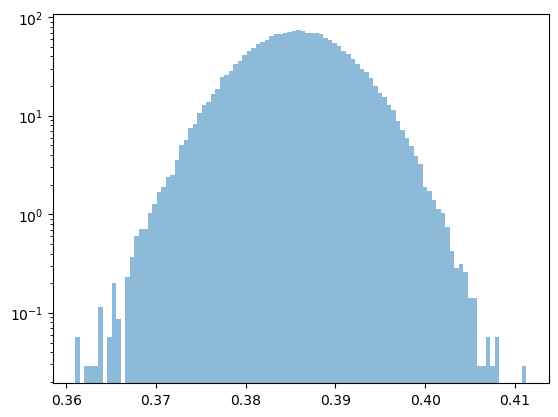

(5, 7)


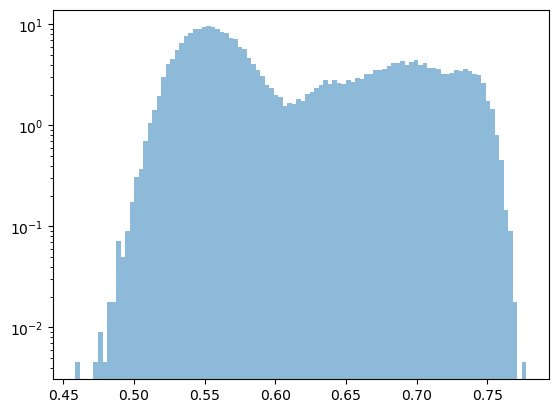

(5, 8)


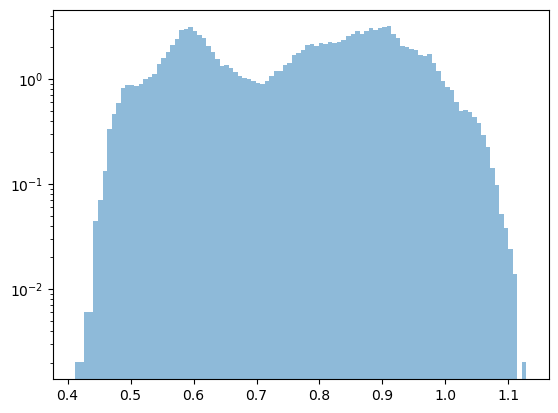

(5, 9)


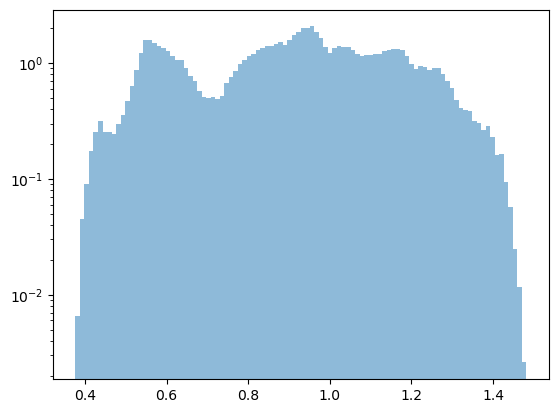

(6, 7)


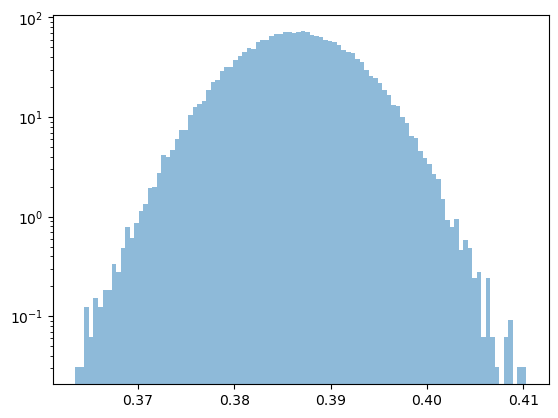

(6, 8)


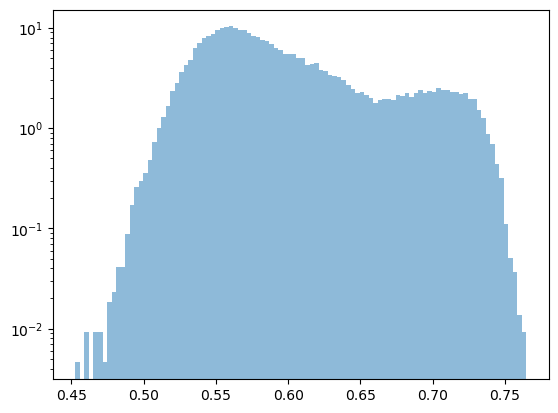

(6, 9)


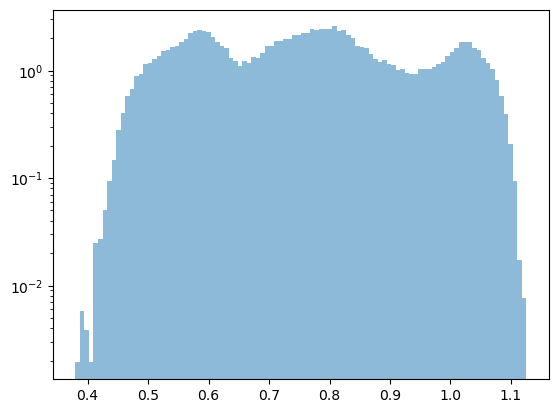

(7, 8)


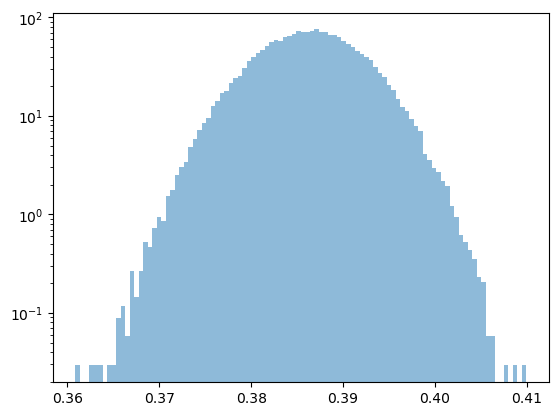

(7, 9)


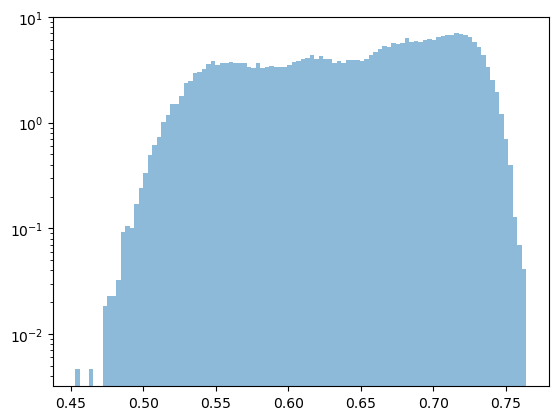

(8, 9)


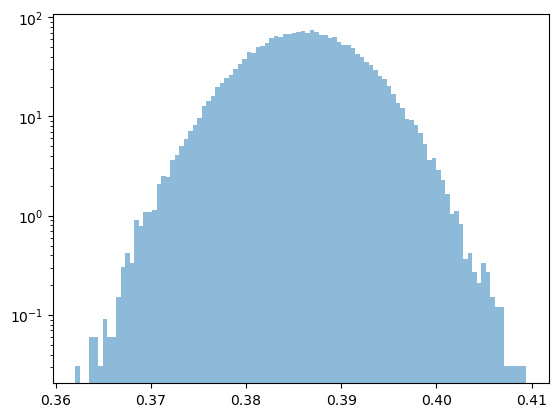

In [37]:
for i in range(all_distances.shape[1]):
    print(ca_atom_pairs[i])
    plt.hist(all_distances[:,i], bins=100, alpha=0.5, density=True)
    plt.yscale('log')
    plt.show()